In [7]:
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display

from soundbay.utils.metadata_processing import add_month_acc_duration, get_dir_wav_info, load_dir_annotation_with_file_time

BASE_PATH = Path(os.getcwd())
DATASET_PATH = BASE_PATH / "datasets/fannie_project"
print(DATASET_PATH)

/mnt/d/DeepVoice/soundbay/datasets/fannie_project


In [8]:
wav_df = get_dir_wav_info(DATASET_PATH)
wav_df = add_month_acc_duration(wav_df)
wav_df.head(3)

,wav_file,duration,sample_rate,rec_id,date_time,month,month_year,accumulated_duration
0,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.025500,96000,5756,2021-04-15 18:29:58,4,4-2021,0.000000
1,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.004667,96000,5756,2021-04-15 19:29:58,4,4-2021,840.025500
2,/mnt/d/DeepVoice/soundbay/datasets/fannie_proj...,840.008000,1000,5756,2021-04-15 20:29:58,4,4-2021,1680.030167


In [9]:
ant_blue_annotation = load_dir_annotation_with_file_time(DATASET_PATH / "ANT_BLUE", DATASET_PATH)

# append CALL types ant_blue annotation
new_ant_blue_annotation = load_dir_annotation_with_file_time(DATASET_PATH / "CallUnitsAndNoise" / "ANT_BLUE", DATASET_PATH, filename_suffix=".Z.unit.1.selections.txt")

ant_blue_annotation = pd.concat([ant_blue_annotation, new_ant_blue_annotation], ignore_index=True)

del new_ant_blue_annotation

mad_blue_annotation = load_dir_annotation_with_file_time(DATASET_PATH / "MAD_BLUE", DATASET_PATH)

# append CALL types mad_blue annotation
new_mad_blue_annotation = load_dir_annotation_with_file_time(DATASET_PATH / "CallUnitsAndNoise" / "MAD_BLUE", DATASET_PATH, filename_suffix=[".Mad.unit.1.selections.txt", ".Mad.unit.2.selections.txt"])

mad_blue_annotation = pd.concat([mad_blue_annotation, new_mad_blue_annotation], ignore_index=True)

del new_mad_blue_annotation

noise_annotation = load_dir_annotation_with_file_time(DATASET_PATH / "CallUnitsAndNoise" / "Noise", DATASET_PATH, filename_suffix=".Noise.selections.txt")


print(f"ANT_BLUE annotation shape: {ant_blue_annotation.shape}")
print(f"MAD_BLUE annotation shape: {mad_blue_annotation.shape}")
print(f"NOISE annotation shape: {noise_annotation.shape}")

ANT_BLUE annotation shape: (5503, 17)
MAD_BLUE annotation shape: (9983, 17)
NOISE annotation shape: (68, 13)


In [10]:
# there is a problem only in march 2022, so we can filter it out
ant_blue_annotation['month_year'] = ant_blue_annotation.apply(lambda x: f"{x['date_time'].month}-{x['date_time'].year}", axis=1)
ant_blue_annotation = ant_blue_annotation[ant_blue_annotation['month_year'] != "3-2022"]
mad_blue_annotation['month_year'] = mad_blue_annotation.apply(lambda x: f"{x['date_time'].month}-{x['date_time'].year}", axis=1)
mad_blue_annotation = mad_blue_annotation[mad_blue_annotation['month_year'] != "3-2022"]

del ant_blue_annotation['month_year']
del mad_blue_annotation['month_year']

ant_blue_annotation.head(3)

,selection,view,channel,begin_time,end_time,high_freq,low_freq,peak_freq,delta_time,dur_90%,snr_nist_quick,wav_file,filename,call_length,date_time,duration,accumulated_duration
0,1,Spectrogram 1,1,831.942378,838.218523,26.831,24.036,25.195,6.2761,5.3805,6.96,5756.210501212958.wav,LF_5756.210501002958,6.276145,2021-05-01 21:29:58,840.016,17640.022
1,2,Spectrogram 1,1,47.070881,53.849117,26.551,23.757,24.609,6.7782,6.0674,9.95,5756.210502002958.wav,LF_5756.210501002958,6.778237,2021-05-02 00:29:58,840.004,20160.030
2,3,Spectrogram 1,1,108.075012,115.982955,26.551,23.477,25.195,7.9079,5.9529,11.75,5756.210502002958.wav,LF_5756.210501002958,7.907943,2021-05-02 00:29:58,840.004,20160.030


In [11]:
# # add class labels
noise_annotation['label'] = 'noise'
ant_blue_annotation['label'] = 'ant_blue'
mad_blue_annotation['label'] = 'mad_blue'

# train, val, test split
train_ant_blue = ant_blue_annotation.sample(frac=0.8, random_state=42)
val_ant_blue = ant_blue_annotation.drop(train_ant_blue.index).sample(frac=0.5, random_state=42)
test_ant_blue = ant_blue_annotation.drop(train_ant_blue.index).drop(val_ant_blue.index)

train_mad_blue = mad_blue_annotation.sample(frac=0.8, random_state=42)
val_mad_blue = mad_blue_annotation.drop(train_mad_blue.index).sample(frac=0.5, random_state=42)
test_mad_blue = mad_blue_annotation.drop(train_mad_blue.index).drop(val_mad_blue.index)

train_noise = noise_annotation.sample(frac=0.8, random_state=42)
val_noise = noise_annotation.drop(train_noise.index).sample(frac=0.5, random_state=42)
test_noise = noise_annotation.drop(train_noise.index).drop(val_noise.index)

# combine all dataframes
train_df = pd.concat([train_ant_blue, train_mad_blue, train_noise], ignore_index=True)
val_df = pd.concat([val_ant_blue, val_mad_blue, val_noise], ignore_index=True)
test_df = pd.concat([test_ant_blue, test_mad_blue, test_noise], ignore_index=True)

# print the shapes of the final dataframes
total_samples = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
print(f"Train set shape: {train_df.shape}, which is: {train_df.shape[0] / total_samples * 100:.2f}%")
print(f"Validation set shape: {val_df.shape}, which is: {val_df.shape[0] / total_samples * 100:.2f}%")
print(f"Test set shape: {test_df.shape}, which is: {test_df.shape[0] / total_samples * 100:.2f}%")


Train set shape: (10372, 18), which is: 80.07%
Validation set shape: (1290, 18), which is: 9.96%
Test set shape: (1291, 18), which is: 9.97%


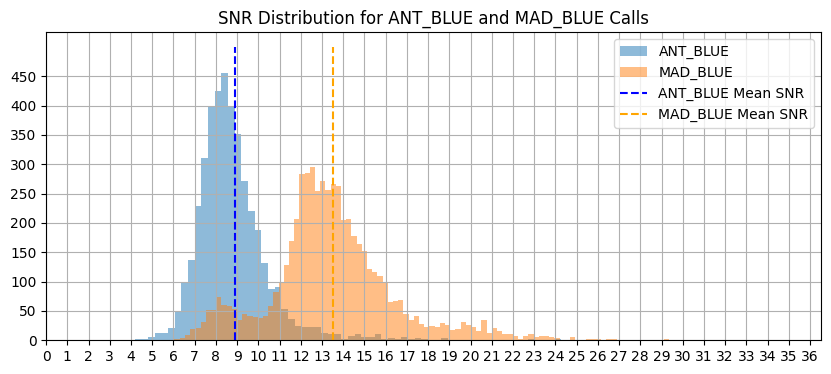

In [12]:
plt.figure(figsize=(10, 4))
plt.hist(train_ant_blue['snr_nist_quick'], bins=100, alpha=0.5, label='ANT_BLUE')
plt.hist(train_mad_blue['snr_nist_quick'], bins=100, alpha=0.5, label='MAD_BLUE')
plt.vlines(train_ant_blue['snr_nist_quick'].mean(), color='blue', linestyle='dashed', linewidth=1.5, ymin=0, ymax=500, label='ANT_BLUE Mean SNR')
plt.vlines(train_mad_blue['snr_nist_quick'].mean(), color='orange', linestyle='dashed', linewidth=1.5, ymin=0, ymax=500, label='MAD_BLUE Mean SNR')


plt.title('SNR Distribution for ANT_BLUE and MAD_BLUE Calls')
plt.xticks(np.arange(0, 37, 1))
plt.yticks(np.arange(0, 500, 50))
plt.legend()
plt.grid()
plt.show()

# View different SNR

show annotations with different SNR from the train dataset

In [13]:
def plot_25_random_samples(m_df, figsize=(15, 15), time_before=0.5, time_after=0.5):
    fig, axes = plt.subplots(5, 5, figsize=figsize)
    sampled_df = m_df.sample(n=25).reset_index(drop=True)
    
    for i, ax in enumerate(axes.flatten()):
        wav_name = sampled_df.loc[i, 'filename'] + '.wav'
        if wav_name.startswith('LF'):
            wav_name = wav_name[3:]  # Remove 'LR_' prefix if present
        if '.txt' in wav_name:
            wav_name = ".".join(wav_name.split('.')[:2]) + '.wav'  # Replace .txt with .wav
        wav_path = DATASET_PATH / wav_name
        wave, sr = librosa.load(wav_path, sr=128)
        
        begin_time = sampled_df.loc[i, 'begin_time'] - time_before
        end_time = sampled_df.loc[i, 'end_time'] + time_after
        signal = wave[int(begin_time * sr):int(end_time * sr)]
        
        # Spectrogram
        S = np.abs(librosa.stft(signal, n_fft=256, hop_length=50))
        S_db = librosa.amplitude_to_db(S, ref=np.max)
        librosa.display.specshow(S_db, sr=sr, hop_length=50, x_axis='time', y_axis='linear', ax=ax, cmap='magma')
    
        ax.set_title(f"Label: {sampled_df['label'].iloc[i]}\n"
                     f"SNR: {sampled_df['snr_nist_quick'].iloc[i]:.2f}dB\n"
                     f"Length: {end_time - begin_time:.2f}s")
    plt.tight_layout()
    plt.show()

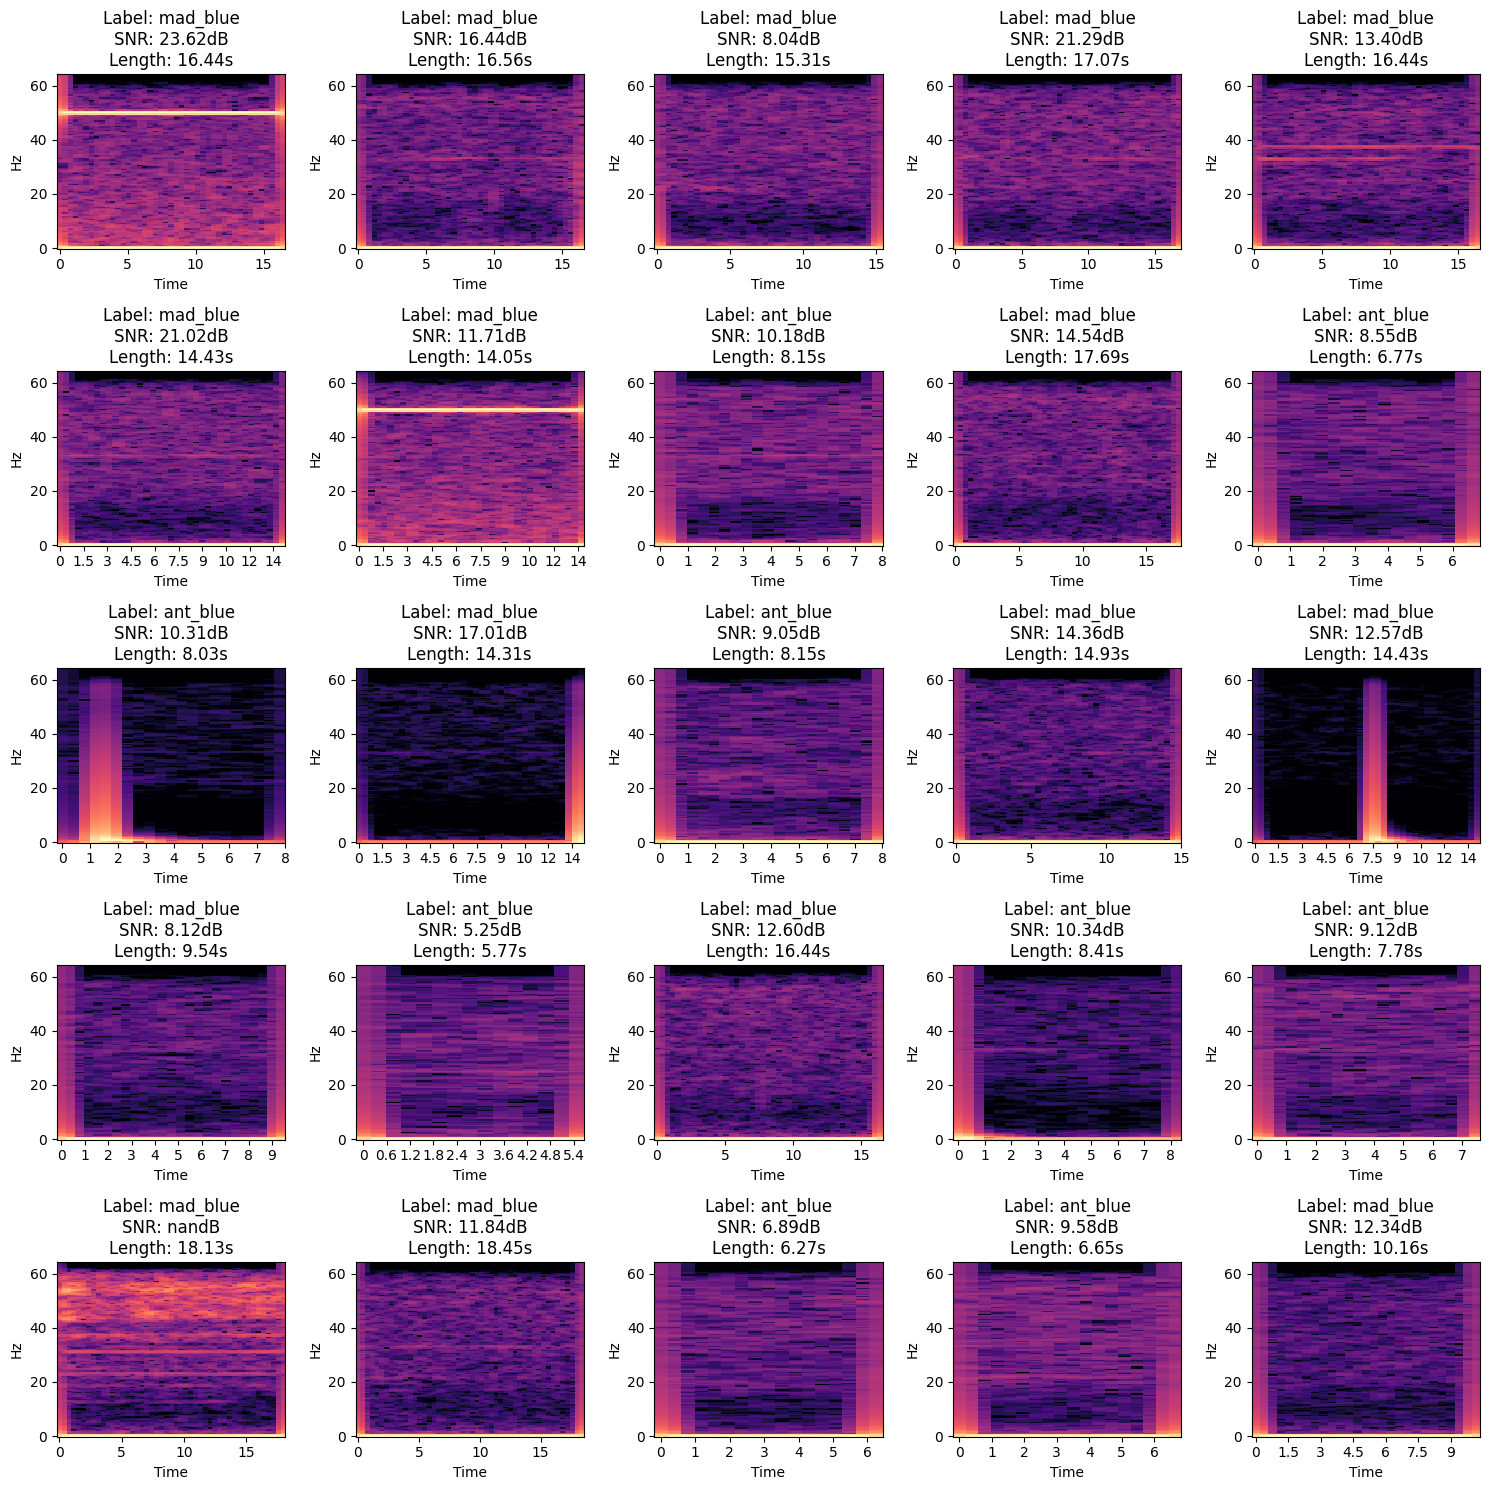

In [14]:
plot_25_random_samples(train_df)

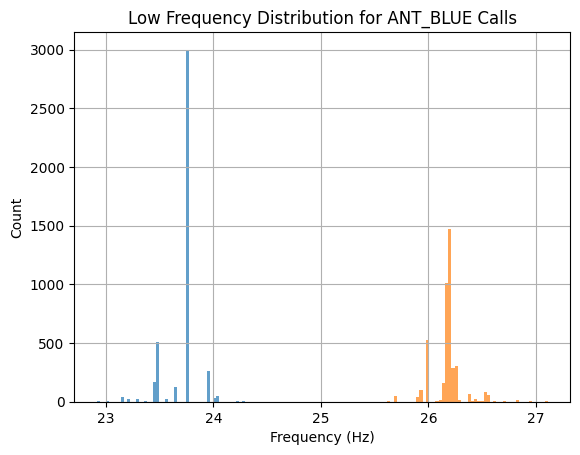

In [15]:
plt.hist(train_df[train_df['label'] == 'ant_blue']['low_freq'], bins=50, alpha=0.7)
plt.hist(train_df[train_df['label'] == 'ant_blue']['high_freq'], bins=50, alpha=0.7)
plt.title('Low Frequency Distribution for ANT_BLUE Calls')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.grid()
plt.show()

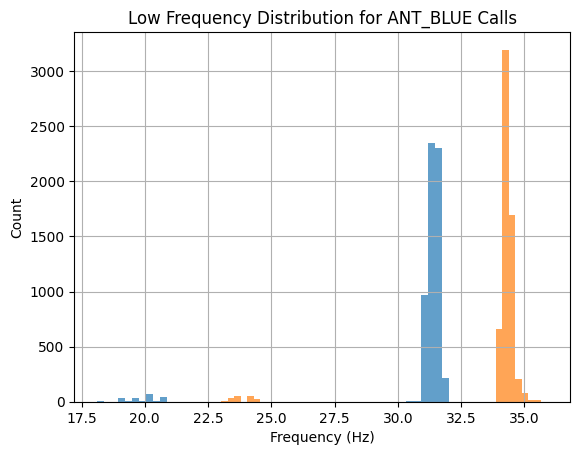

In [16]:
plt.hist(train_df[train_df['label'] == 'mad_blue']['low_freq'], bins=50, alpha=0.7)
plt.hist(train_df[train_df['label'] == 'mad_blue']['high_freq'], bins=50, alpha=0.7)
plt.title('Low Frequency Distribution for ANT_BLUE Calls')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.grid()
plt.show()

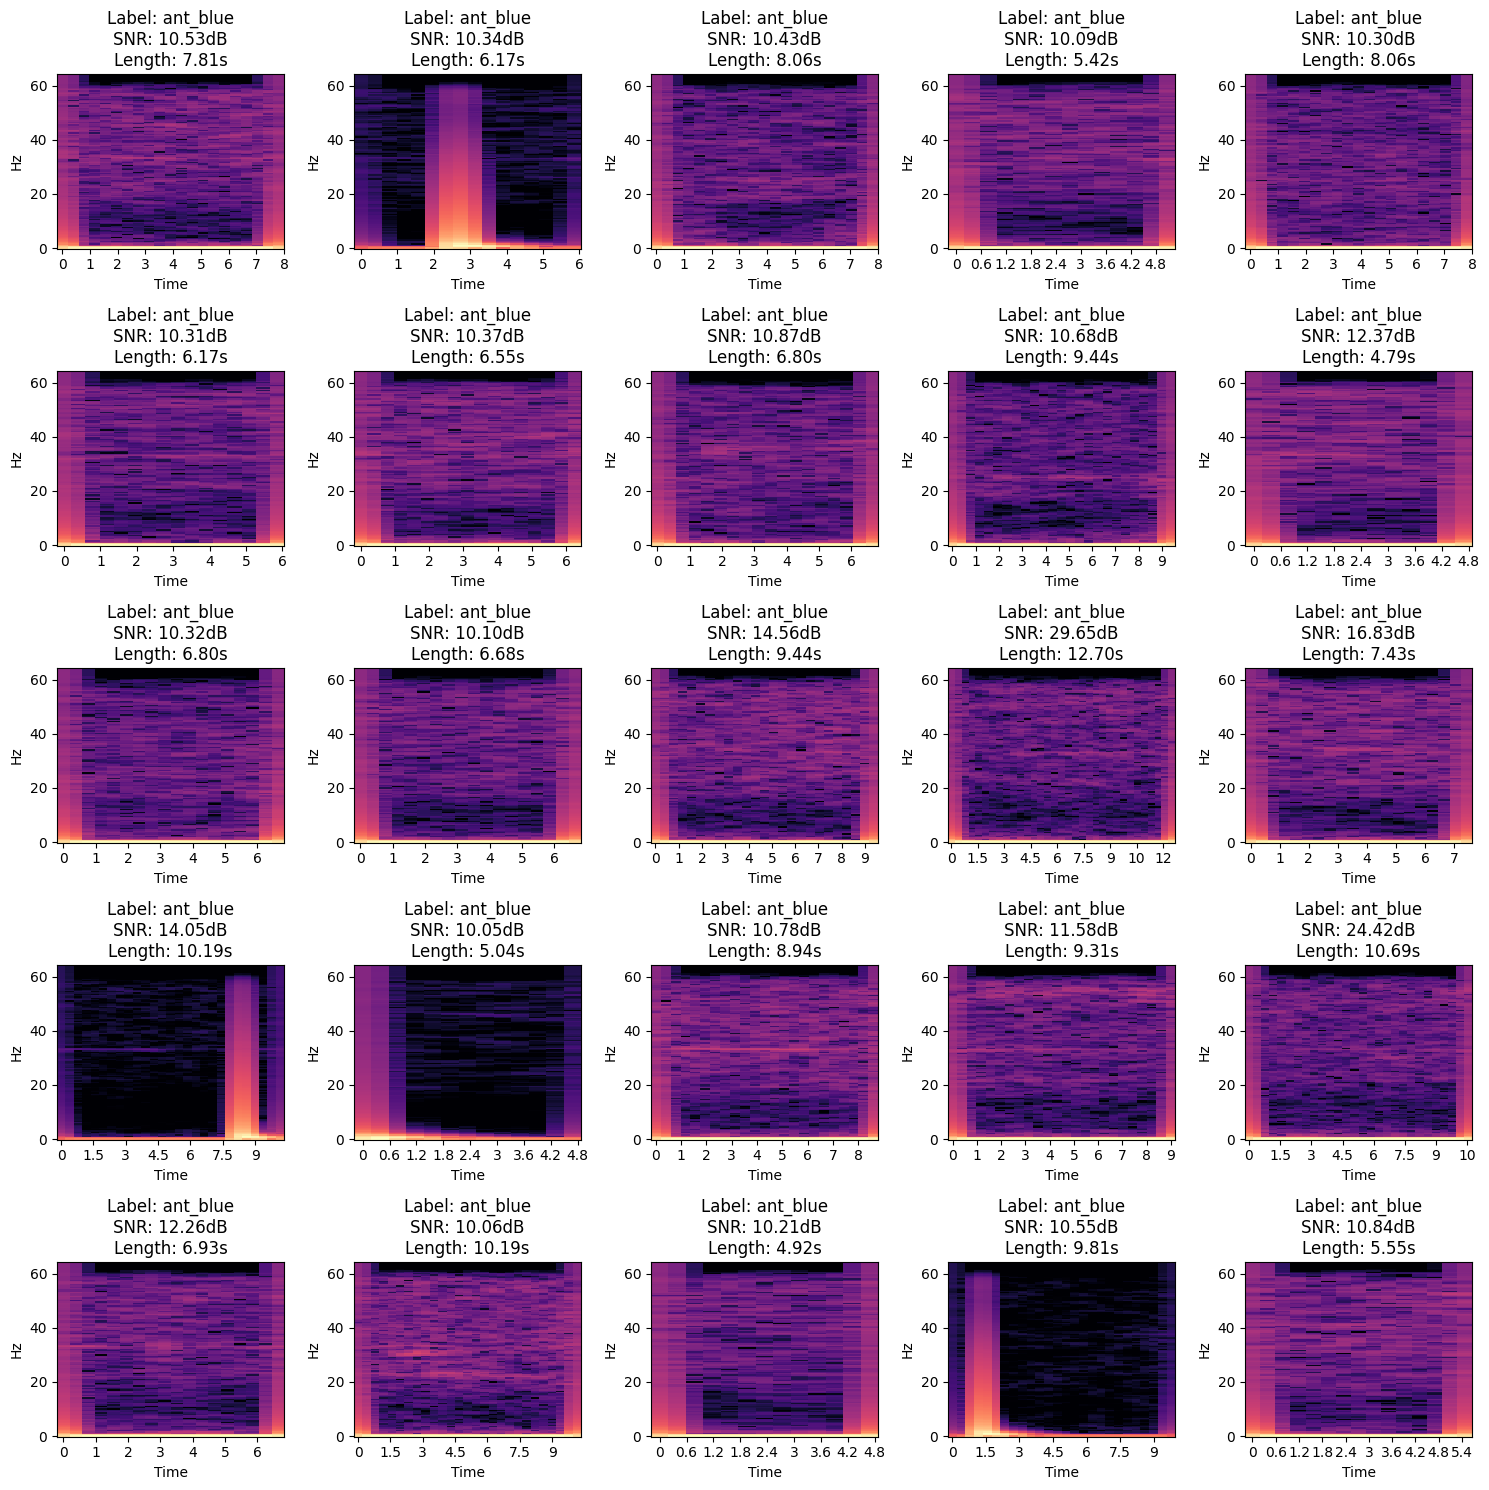

In [17]:
plot_25_random_samples(train_df[(train_df['label'] == 'ant_blue') & (train_df['snr_nist_quick'] > 10)], time_before=0.2, time_after=0.2)

In [18]:
train_df.head(3)

,selection,view,channel,begin_time,end_time,high_freq,low_freq,peak_freq,delta_time,dur_90%,snr_nist_quick,wav_file,filename,call_length,date_time,duration,accumulated_duration,label
0,110,Spectrogram 1,1,251.371428,258.149664,26.179,23.750,24.609,6.7782,6.1819,9.38,5756.210602142958.wav,LF_5756.210601002958,6.778237,2021-06-02 14:29:58,839.999,31920.324,ant_blue
1,262,Spectrogram 1,1,545.393381,552.673709,26.169,23.663,25.195,7.2803,4.9226,10.17,5756.220413063455.wav,LF_5756.220401003455,7.280328,2022-04-13 06:34:55,839.983,246961.669,ant_blue
2,750,Spectrogram 1,1,133.702498,140.480735,26.200,23.752,24.609,6.7782,5.4950,8.17,5756.210728092958.wav,LF_5756.210701002958,6.778237,2021-07-28 09:29:58,840.019,551884.490,ant_blue


In [19]:
low_snr_ant_blue = train_ant_blue[train_ant_blue['snr_nist_quick'] < 8].copy()
mid_snr_ant_blue = train_ant_blue[(train_ant_blue['snr_nist_quick'] >= 8) & (train_ant_blue['snr_nist_quick'] <= 16)].copy()
high_snr_ant_blue = train_ant_blue[train_ant_blue['snr_nist_quick'] > 16].copy()
low_snr_ant_blue['label'] = 'low_snr_ant_blue'
mid_snr_ant_blue['label'] = 'mid_snr_ant_blue'
high_snr_ant_blue['label'] = 'high_snr_ant_blue'

low_snr_ant_blue.shape, mid_snr_ant_blue.shape, high_snr_ant_blue.shape

((1349, 18), (2816, 18), (54, 18))

In [20]:
low_file_names = low_snr_ant_blue['wav_file'].unique().tolist()
mid_file_names = mid_snr_ant_blue['wav_file'].unique().tolist()
high_file_names = high_snr_ant_blue['wav_file'].unique().tolist()

# find files that are common in all three lists
common_files = set(low_file_names) & set(mid_file_names) & set(high_file_names)
common_files_list = list(common_files)
print(f"Number of common files across all SNR categories: {len(common_files_list)}")
common_files_list[:5]  # display first 5 common files

Number of common files across all SNR categories: 4


['5756.220414073455.wav',
 '5756.210506112958.wav',
 '5756.220414103455.wav',
 '5756.210525092958.wav']

In [21]:
# create raven sample selection files for these common files
wanted_file = common_files_list[2]
snr_df = pd.concat([
    low_snr_ant_blue[low_snr_ant_blue['wav_file'] == wanted_file],
    mid_snr_ant_blue[mid_snr_ant_blue['wav_file'] == wanted_file],
    high_snr_ant_blue[high_snr_ant_blue['wav_file'] == wanted_file]
])

# choose wanted columns
snr_df = snr_df[['selection', 'begin_time', 'end_time', 'low_freq', 'high_freq', 'channel', 'label', 'snr_nist_quick']].copy()

# change column names:
snr_df.columns = ['Selection', 'Begin Time (s)', 'End Time (s)', 'Low Freq (Hz)', 'High Freq (Hz)', 'Channel', 'Label', 'SNR (dB)']

print(snr_df.shape)

snr_df.to_csv(f"/mnt/d/{wanted_file}_snr_comparison_ant_blue.txt", sep="\t", index=False)
print(f"{wanted_file}_snr_comparison_ant_blue.txt")


(5, 8)
5756.220414103455.wav_snr_comparison_ant_blue.txt


In [22]:
high_snr_ant_blue[high_snr_ant_blue['wav_file'] == common_files_list[0]].shape

(1, 18)

 Check for low SNR madagascar:

In [23]:
low_snr_mad_blue = train_mad_blue[train_mad_blue['snr_nist_quick'] < 8].copy()
mid_snr_mad_blue = train_mad_blue[(train_mad_blue['snr_nist_quick'] >= 8) & (train_mad_blue['snr_nist_quick'] <= 16)].copy()
high_snr_mad_blue = train_mad_blue[train_mad_blue['snr_nist_quick'] > 16].copy()
low_snr_mad_blue['label'] = 'low_snr_mad_blue'
mid_snr_mad_blue['label'] = 'mid_snr_mad_blue'
high_snr_mad_blue['label'] = 'high_snr_mad_blue'
low_snr_mad_blue.shape, mid_snr_mad_blue.shape, high_snr_mad_blue.shape

low_file_names = low_snr_mad_blue['wav_file'].unique().tolist()
mid_file_names = mid_snr_mad_blue['wav_file'].unique().tolist()
high_file_names = high_snr_mad_blue['wav_file'].unique().tolist()

# find files that are common in all three lists
common_files = set(low_file_names) & set(mid_file_names) & set(high_file_names)
common_files_list = list(common_files)
print(f"Number of common files across all SNR categories: {len(common_files_list)}")
common_files_list[:5]  # display first 5 common files

Number of common files across all SNR categories: 21


['5756.220217013455.wav',
 '5756.220414113455.wav',
 '5756.220220113455.wav',
 '5756.220414123455.wav',
 '5756.210428012958.wav']

In [24]:
# find files with only low snr:
only_low_snr_files = set(low_file_names) - (set(mid_file_names) | set(high_file_names))
print(f"Number of files with only low SNR: {len(only_low_snr_files)}")

# for each file in only_low_snr_files, check how many entries are there in low_snr_mad_blue
for file in only_low_snr_files:
    entries = low_snr_mad_blue[low_snr_mad_blue['wav_file'] == file]
    if entries.shape[0] > 1:
        print(f"File: {file}, Number of entries: {entries.shape[0]}")

list(only_low_snr_files)[:5]  # display first 5

Number of files with only low SNR: 37


['5756.210512182958.wav',
 '5756.220405183455.wav',
 '5756.220120112958.wav',
 '5756.210426142958.wav',
 '5756.220122003455.wav']

In [25]:
# create raven sample selection files for these common files
wanted_file = common_files_list[2]
snr_df = pd.concat([
    low_snr_mad_blue[low_snr_mad_blue['wav_file'] == wanted_file],
    mid_snr_mad_blue[mid_snr_mad_blue['wav_file'] == wanted_file],
    high_snr_mad_blue[high_snr_mad_blue['wav_file'] == wanted_file]
])

# choose wanted columns
snr_df = snr_df[['selection', 'begin_time', 'end_time', 'low_freq', 'high_freq', 'channel', 'label', 'snr_nist_quick']].copy()

# change column names:
snr_df.columns = ['Selection', 'Begin Time (s)', 'End Time (s)', 'Low Freq (Hz)', 'High Freq (Hz)', 'Channel', 'Label', 'SNR (dB)']

print(snr_df.shape)

snr_df.to_csv(f"/mnt/d/{wanted_file}_snr_comparison_mad_blue.txt", sep="\t", index=False)
print(f"{wanted_file}_snr_comparison_mad_blue.txt")

(3, 8)
5756.220220113455.wav_snr_comparison_mad_blue.txt


we see that SNR 8 is good cutoff for antarctic blue whale, but does not really matter for madagascar pigmey whales

## create mid-high SNR dataset

label
2    6051
1    3602
0      54
Name: count, dtype: int64


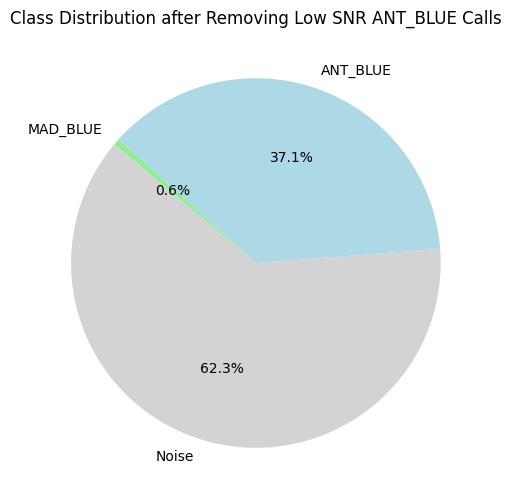

In [26]:
train_noise['label'] = 0
ant_blue_annotation['label'] = 1
train_mad_blue['label'] = 2

## remove ant_blue with low snr
high_snr_ant_blue_annotation = ant_blue_annotation[ant_blue_annotation['snr_nist_quick'] >= 8]

## check how many are for each class by pie graph
class_counts = pd.concat([train_noise['label'], high_snr_ant_blue_annotation['label'], train_mad_blue['label']]).value_counts()
print(class_counts)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Noise', 'ANT_BLUE', 'MAD_BLUE'], autopct='%1.1f%%', startangle=140, colors=['lightgray', 'lightblue', 'lightgreen'])
plt.title('Class Distribution after Removing Low SNR ANT_BLUE Calls')
plt.show()

label
1    6051
2    6051
0      54
Name: count, dtype: int64


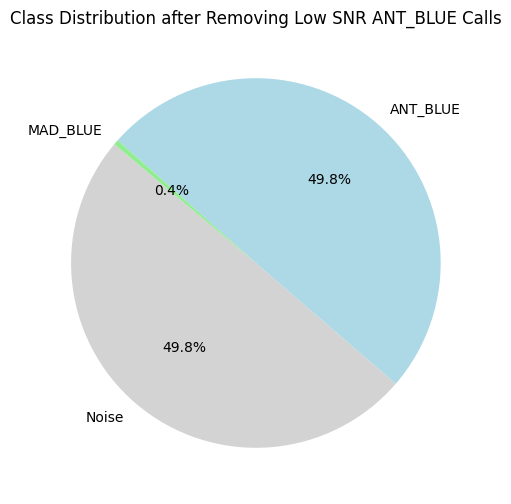

In [27]:
# upsample high_snr_ant_blue_annotation to match mad_blue_annotation
from sklearn.utils import resample
upsampled_ant_blue = resample(
    high_snr_ant_blue_annotation,
    replace=True,
    n_samples=train_mad_blue.shape[0],
    random_state=42
)
## check how many are for each class by pie graph
class_counts = pd.concat([train_noise['label'], upsampled_ant_blue['label'], train_mad_blue['label']]).value_counts()
print(class_counts)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Noise', 'ANT_BLUE', 'MAD_BLUE'], autopct='%1.1f%%', startangle=140, colors=['lightgray', 'lightblue', 'lightgreen'])
plt.title('Class Distribution after Removing Low SNR ANT_BLUE Calls')
plt.show()

In [44]:
## Add november data to train:
# Filter wav_df for files recorded in November (month == 11)
november_wavs = wav_df[wav_df.date_time.dt.month == 11]

def generate_november_sampled_df(n_samples, target_mean, target_std, november_wavs, random_state):
    # columns = annotation_df.columns

    # Randomly sample wav files for November
    sampled_wavs = november_wavs.sample(n=n_samples, replace=True, random_state=random_state).reset_index(drop=True)

    # Generate random durations with the same mean and std as annotation_df
    np.random.seed(random_state)
    delta_times = np.random.normal(loc=target_mean, scale=target_std, size=n_samples)
    delta_times = np.clip(delta_times, 0.1, None)

    # Generate random begin times within each wav file's duration
    begin_times = []
    end_times = []
    for i, row in sampled_wavs.iterrows():
        max_start = max(row['duration'] - delta_times[i], 0.1)
        # if delta_times[i] < 2:
        begin = np.random.uniform(0, max_start)
        end = begin + delta_times[i]
        begin_times.append(begin)
        end_times.append(end)

    # Build the DataFrame
    sampled_df = pd.DataFrame({
        'wav_file': sampled_wavs['wav_file'],
        'begin_time': begin_times,
        'end_time': end_times,
        'call_length': delta_times
    })

    return sampled_df

In [35]:
print(upsampled_ant_blue.shape[0])
print(train_mad_blue.shape[0])

6051
6051


3025
November sampled ANT calls shape: (3025, 4)
November sampled MAD calls shape: (3025, 4)
together: 6050
Noise annotation shape after adding sampled ANT and MAD calls: (6104, 14)
label
0    6104
1    6051
2    6051
Name: count, dtype: int64


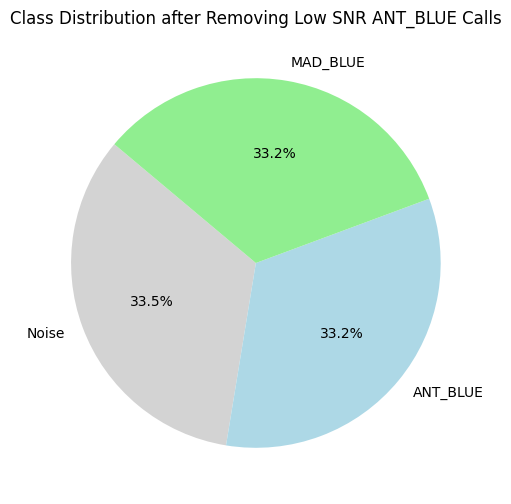

In [51]:
n_samples = upsampled_ant_blue.shape[0] // 2# + train_mad_blue.shape[0] // 2 - train_noise.shape[0]
print(n_samples)
november_sampled_ant_df = generate_november_sampled_df(
    n_samples,
    upsampled_ant_blue['delta_time'].mean(),
    upsampled_ant_blue['delta_time'].std(),
    november_wavs,
    random_state=42
)

november_sampled_mad_df = generate_november_sampled_df(
    n_samples,
    train_mad_blue['delta_time'].mean(),
    train_mad_blue['delta_time'].std(),
    november_wavs,
    random_state=42
)

print(f"November sampled ANT calls shape: {november_sampled_ant_df.shape}")
print(f"November sampled MAD calls shape: {november_sampled_mad_df.shape}")
print(f"together: {november_sampled_ant_df.shape[0] + november_sampled_mad_df.shape[0]}")

# november_sampled_ant_df.head(), november_sampled_mad_df.head()
noise_annotation = pd.concat([train_noise, november_sampled_ant_df, november_sampled_mad_df], ignore_index=True)
print(f"Noise annotation shape after adding sampled ANT and MAD calls: {noise_annotation.shape}")
noise_annotation = noise_annotation[['wav_file', 'begin_time', 'end_time', 'call_length']]
noise_annotation['label'] = 0

class_counts = pd.concat([noise_annotation['label'], upsampled_ant_blue['label'], train_mad_blue['label']]).value_counts()
print(class_counts)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Noise', 'ANT_BLUE', 'MAD_BLUE'], autopct='%1.1f%%', startangle=140, colors=['lightgray', 'lightblue', 'lightgreen'])
plt.title('Class Distribution after Removing Low SNR ANT_BLUE Calls')
plt.show()

In [64]:
# noise_annotation['wav_file'].head()
upsampled_ant_blue['wav_file'].head()

4620    5756.220418143455.wav
5183    5756.220502213455.wav
1042    5756.210531182958.wav
1609    5756.210611042958.wav
1395    5756.210607042958.wav
Name: wav_file, dtype: object

In [65]:
def format_annotation_for_training(df):
    df['begin_time'] = df['begin_time'].astype(float)
    df['end_time'] = df['end_time'].astype(float)
    df['call_length'] = df['end_time'] - df['begin_time']

    df.rename(columns={'wav_file': 'filename'}, inplace=True)
    df['filename'] = df['filename'].apply(lambda x: str(x).replace('.wav', ''))
    df['filename'] = df['filename'].apply(lambda x: x.split('/')[-1])  # keep only the file name

    df['label'] = df['label'].astype(int)
    return df

In [69]:
from soundbay.utils.metadata_processing import multi_target_from_time_intervals_df

In [74]:
# TODO: add call_length

# create files in the right format:
save_ant_blue = upsampled_ant_blue[['wav_file', 'begin_time', 'end_time', 'call_length', 'label']]
save_ant_blue = format_annotation_for_training(save_ant_blue)
# save_ant_blue.columns = ['filename', 'begin_time', 'end_time', 'call_length', 'label']

save_mad_blue = train_mad_blue[['wav_file', 'begin_time', 'end_time', 'call_length', 'label']]
save_mad_blue = format_annotation_for_training(save_mad_blue)
# save_mad_blue.columns = ['filename', 'begin_time', 'end_time', 'call_length', 'label']

save_noise = noise_annotation[['wav_file', 'begin_time', 'end_time', 'call_length', 'label']]
save_noise = format_annotation_for_training(save_noise)
# save_noise.columns = ['filename', 'begin_time', 'end_time', 'call_length', 'label']

# save as new train metadata
train_metadata = pd.concat([save_noise, save_ant_blue, save_mad_blue], ignore_index=True)
# remove .wav from all train metadata filenames
# train_metadata['filename'] = train_metadata['filename'].apply(lambda x: x.replace('.wav', ''))

train_metadata['label'] = multi_target_from_time_intervals_df(
    train_metadata,
    n_classes=3,
    overlap_threshold_pct=0.1,
    noise_class_value=0
)

print(train_metadata.head(3))

train_metadata.to_csv(DATASET_PATH / "train_metadata_after_snr_filtering.csv", index=False)
print(f"Train metadata shape: {train_metadata.shape}")

/tmp/ipykernel_1732841/1519937948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['begin_time'] = df['begin_time'].astype(float)
/tmp/ipykernel_1732841/1519937948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = df['end_time'].astype(float)
/tmp/ipykernel_1732841/1519937948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

            filename  begin_time    end_time  call_length      label
0  5756.210601012958  178.156886  196.212719    18.055832  [0, 0, 0]
1  5756.210502062958   80.479499  120.500158    40.020659  [0, 0, 0]
2  5756.210426172958  196.435881  239.807108    43.371226  [0, 0, 0]
Train metadata shape: (18206, 5)


In [75]:
train_metadata['label'].value_counts()

label
[1, 1, 0]    11998
[0, 0, 0]     6104
[0, 1, 0]      104
Name: count, dtype: int64